In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/nlp_1/scripts')
from utils import get_word2ix, get_files, process_data
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
torch.manual_seed(42)   # Random seed set

In [3]:
word2ix={}
word2ix = get_word2ix("/content/drive/MyDrive/nlp_1/vocab.txt")
print(word2ix["[UNK]"])
train_files=get_files("/content/drive/MyDrive/nlp_1/data/train")
train_data = process_data(train_files, 5, word2ix)
dev_files=get_files("/content/drive/MyDrive/nlp_1/data/dev")
dev_data = process_data(dev_files, 5, word2ix)

18058


In [4]:
training_list=[]
label_list=[]
for i in range(len(train_data)):
  for j in range(5,len(train_data[i])-5):
    temp = []
    for k in range(-5,6):
      if(k!=0):
        temp.append(train_data[i][j+k])
    training_list.append(temp.copy())
    label_list.append(train_data[i][j])
dev_list=[]
dev_label_list=[]
for i in range(len(dev_data)):
  for j in range(5,len(dev_data[i])-5):
    temp = []
    for k in range(-5,6):
      if(k!=0):
        temp.append(dev_data[i][j+k])
    dev_list.append(temp.copy())
    dev_label_list.append(dev_data[i][j])


In [5]:

class MLP(torch.nn.Module):
  def __init__(self,vocab_len, hid_dim, out_dim):
    """ This is the constructor. Initialize your network
    layers here.
    Inputs
    --------
    in_dim: int. Dimension of your input. It was 2 in the example
    hid_dim: int. Dimension of the intermediate level. Also 2 in the example
    out_dim: int. Dimension of your output. It was 1 in the example
    """
    super().__init__()
    self.embed = torch.nn.Embedding(vocab_len, hid_dim)        # Invoke the constructor of the parent class
    self.w = torch.nn.Linear(hid_dim, out_dim)

  def forward(self, inp):
    """ Method for forward pass
    Input
    -------
    inp: torch.Tensor. The dimension of the input (i.e, the last number in shape)
        should match `in_dim`. The shape should be (n,in_dim) where n is the batch size

    Output
    ------
    z: torch.Tensor. The result of the forward pass. The dimension of the output
     (i.e, the last number in shape) should match `out_dim`. The shape should be
     (n, out_dim) where n is the batch size.
    """
    z = self.w(torch.sum(self.embed(inp),dim=1))
    return z

device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
model = MLP(vocab_len =18060, hid_dim=100, out_dim=18060).to(device)
#a = torch.tensor([[1,2],[3,4]], dtype=torch.float)
#z = model(a)

# Side note: Moving models to GPUs is simple. Use the `.to()` method.
# model = MLP(in_dim=2, hid_dim=2, out_dim=1).to("cuda")
# All the layer weights will be moved to the GPU
# Note that all your input tensors should also be on the GPU for this.

#print(z)

In [6]:
train_dataset = TensorDataset(
                          torch.tensor(training_list, dtype = torch.int),
                          torch.tensor(label_list))
dev_dataset = TensorDataset(
                          torch.tensor(dev_list, dtype = torch.int),
                          torch.tensor(dev_label_list))

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
from tqdm import tqdm   # This library allows us to see how far in the epoch we are
import numpy as np
import time
from sklearn.metrics import f1_score

# We need to decide what device we'll be using for our model computations
# The following like says that if any GPU is available, then use it.
# Otherwise, we use a CPU
# device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

max_epochs = 10

best_perf_dict = {"metric": 0, "epoch": 0}

# Create a randomly initialized model and the optimizer.
# model = MLP(in_dim=16, hid_dim=12, out_dim=7).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Begin the training loop
for ep in range(1, max_epochs+1):
    print(f"\nEpoch {ep}")
    train_loss = []       # We will use this list to accumulate losses and observe if training is happening

    # We load data in batches from the loader and will do backpropagation
    # for this batch of inputs in every iteration
    for inp, lab in tqdm(train_loader):
        # Switch to train mode
        # This doesn't make a difference to our model but is considered good practice
        # Models might contain layers like Dropout which behave differently when training
        # versus evaluating. This signals these layers to behave appropriately.
        model.train()

        # PyTorch accumulates gradients for every `.backward()`
        # This means if we do not set it to zero, it will add up all the
        # gradients it has seen till that moment.
        optimizer.zero_grad()

        # Let us check what the input and the label shapes are
        # print(f"\nInput shape: {inp.shape}")
        # print(f"Label shape: {lab.shape}")

        out = model(inp.to(device))    #Forward pass
        # print(f"Output shape: {out.shape}")  # Output shape

        # We have the output logits and the labels. We can compute the loss now
        loss = loss_fn(out, lab.to(device))

        # print(f"Loss: {loss} with shape {loss.shape}")

        loss.backward() # computing the gradients
        optimizer.step()  # Performs the optimization

        train_loss.append(loss.cpu().item())    # Appending the batch loss to the list

    print(f"Average training batch loss: {np.mean(train_loss)}")

        # Evaluation Loop
    gold_labels = []
    pred_labels = []
    for inp, lab in tqdm(dev_loader):
        # Switch to eval mode
        model.eval()
        # Gradient accumulation is time-consuming
        # It is best to tell torch not to record gradients during evaluation
        # because we don't need it
        with torch.no_grad():
            out = model(inp.to(device))
            preds = torch.argmax(out, dim=1)
            pred_labels.extend(preds.cpu().tolist())
            gold_labels.extend(lab.tolist())

    dev_f1 = f1_score(gold_labels, pred_labels, average='macro')
    print(f"Dev F1: {dev_f1}\n")

    # Update the `best_perf_dict` if the best dev performance seen
    # so far is beaten
    if dev_f1 > best_perf_dict["metric"]:
        best_perf_dict["metric"] = dev_f1
        best_perf_dict["epoch"]  = ep
        torch.save({
            "model_param": model.state_dict(),
            "optim_param": optimizer.state_dict(),
            "dev_metric": dev_f1,
            "epoch": ep
        }, f"./models/{ep}")


Epoch 1


100%|██████████| 29073/29073 [01:32<00:00, 314.89it/s]


Average training batch loss: 6.576034108030945


100%|██████████| 2420/2420 [00:02<00:00, 857.45it/s] 


Dev F1: 0.0006242827984348459


Epoch 2


100%|██████████| 29073/29073 [01:28<00:00, 328.07it/s]


Average training batch loss: 6.108672612731853


100%|██████████| 2420/2420 [00:03<00:00, 715.56it/s]


Dev F1: 0.0008543548648567822


Epoch 3


100%|██████████| 29073/29073 [01:28<00:00, 326.72it/s]


Average training batch loss: 5.930706427906155


100%|██████████| 2420/2420 [00:02<00:00, 1097.87it/s]


Dev F1: 0.001001394007882931


Epoch 4


100%|██████████| 29073/29073 [01:33<00:00, 310.25it/s]


Average training batch loss: 5.793250851638873


100%|██████████| 2420/2420 [00:02<00:00, 1086.30it/s]


Dev F1: 0.0011192204666898094


Epoch 5


100%|██████████| 29073/29073 [01:32<00:00, 314.63it/s]


Average training batch loss: 5.675738525190528


100%|██████████| 2420/2420 [00:02<00:00, 1080.80it/s]


Dev F1: 0.0012951937624797359


Epoch 6


100%|██████████| 29073/29073 [01:32<00:00, 312.64it/s]


Average training batch loss: 5.571374799569432


100%|██████████| 2420/2420 [00:02<00:00, 1061.53it/s]


Dev F1: 0.0012389651338830321


Epoch 7


100%|██████████| 29073/29073 [01:45<00:00, 275.75it/s]


Average training batch loss: 5.48209018869321


100%|██████████| 2420/2420 [00:03<00:00, 798.53it/s]


Dev F1: 0.0013873145884415706


Epoch 8


100%|██████████| 29073/29073 [01:52<00:00, 258.94it/s]


Average training batch loss: 5.4056219324109245


100%|██████████| 2420/2420 [00:02<00:00, 1098.63it/s]


Dev F1: 0.0014167380981360714


Epoch 9


100%|██████████| 29073/29073 [01:31<00:00, 318.43it/s]


Average training batch loss: 5.343105168803961


100%|██████████| 2420/2420 [00:02<00:00, 1004.92it/s]


Dev F1: 0.0013151756361311773


Epoch 10


100%|██████████| 29073/29073 [01:30<00:00, 322.37it/s]


Average training batch loss: 5.289857508256841


100%|██████████| 2420/2420 [00:02<00:00, 976.43it/s]


Dev F1: 0.0016543272559019998



In [9]:
best_epoch = best_perf_dict["epoch"]
model_path = f"./models/{best_epoch}"
checkpoint = torch.load(model_path)

model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])

print(f"""Dev F1 of loaded model: {checkpoint["dev_metric"]} at epoch {checkpoint["epoch"]}""")


def evaluate(loader, model):
    """ Just a method to evaluate a loader w.r.t a model
    Inputs
    --------
    loader: torch.data.DataLoader. Should have a TensorDataset with a tensor for features
              and labels each.
    model: Model. instance of class Model

    Output
    -------
    f1: float. F1 score computed
    """
    # Evaluation Loop
    gold_labels = []
    pred_labels = []
    for inp, lab in tqdm(loader):
        # Switch to eval mode
        model.eval()
        # Gradient accumulation is time-consuming
        # It is best to tell torch not to record gradients during evaluation
        # because we don't need it
        with torch.no_grad():
            out = model(inp.to(device))
            preds = torch.argmax(out, dim=1)

            pred_labels.extend(preds.cpu().tolist())
            gold_labels.extend(lab.tolist())

    f1 = f1_score(gold_labels, pred_labels, average='macro')
    return f1


# Would like to verify if the model still gives the same F1
# after model has been loaded. This helps identify if there
# are any random seed errors or something bugging which might affect reproducibility
print(f"\nDev F1: {evaluate(dev_loader, model)}\n")
# print(f"\nTest F1: {evaluate(test_loader, model)}\n")

Dev F1 of loaded model: 0.0016543272559019998 at epoch 10


100%|██████████| 2420/2420 [00:03<00:00, 753.73it/s]



Dev F1: 0.0016543272559019998



In [10]:
final_weights = list(model.w.parameters())[0].detach().cpu().numpy()

In [11]:
print(final_weights.shape)

(18060, 100)


In [12]:
file1 = open("embeddings.txt", "w")

In [13]:
L =["18060 100\n"]
for key in word2ix:
  temp = key
  i= word2ix[key]
  for j in range(len(final_weights[i])):
    temp = temp +" "+str(final_weights[i][j])
  temp = temp+"\n"
  L.append(temp)



In [14]:
print(L[18059])

fenton 0.25664014 -0.42765954 -0.14562254 0.22567973 -0.25340152 -0.1933382 0.5862153 0.0029089358 0.087701686 -0.07753981 0.05943947 0.44936645 0.371833 0.26824296 0.42214116 -0.12297321 -0.2498958 0.06096002 0.38048813 -0.25477552 0.043385614 0.27359515 -0.07751218 0.11753851 -0.26130733 -0.23378548 -0.29621038 0.015453224 -0.31097877 -0.31628165 -0.08099068 -0.020173293 0.12773323 0.39107293 0.14994724 0.06236211 0.18219155 -0.097828 0.095942624 -0.14074701 0.16052006 -0.27769104 -0.081748374 -0.28911328 0.220322 0.26159546 0.32147238 -0.25591218 0.39088812 -0.2119213 0.1952316 -0.23629987 0.17478555 -0.452828 -0.53111494 -0.0818036 0.19663043 0.18777955 0.34786695 0.11299247 0.3739864 -0.20541374 0.33364362 -0.17912474 0.078786284 0.027137911 -0.23154274 0.1592201 0.13651326 0.36499837 0.06830017 0.058079712 0.20198373 -0.38174784 0.010679162 -0.22303343 -0.16334103 0.19622482 0.34705585 0.09186252 -0.08518488 -0.3590731 0.33737656 0.29874623 0.16075188 0.25870013 0.40121758 0.1164

In [15]:
file1.writelines(L)
file1.close()

In [16]:
!python /content/drive/MyDrive/nlp_1/scripts/eval_embs.py --emb_file "/content/embeddings.txt"

Word Similarity Test Pearson Correlation: 0.15859909890100438
Accuracy on Analogy Test: 0.023882896764252697


SIMILARITY SCORE

In [25]:
import math
def similarity_score(w1,w2):
  v1= final_weights[word2ix[w1]]
  v2= final_weights[word2ix[w2]]
  prod = np.dot(v1,v2)/(math.sqrt(np.dot(v1,v1))*math.sqrt(np.dot(v2,v2)))
  return prod

In [26]:
print(similarity_score('cat','tiger'))

0.9114503852453678


In [27]:
print(similarity_score('plane','human'))

0.881268666821219


In [28]:
print(similarity_score('my','mine'))

0.9203765474938723


In [29]:
print(similarity_score('happy','human'))

0.8982451581687754


In [30]:
print(similarity_score('happy','cat'))

0.8885217459317221


In [31]:
print(similarity_score('king','princess'))

0.8859308216103752


In [32]:
print(similarity_score('ball','racket'))

0.8959974026481757


In [33]:
print(similarity_score('good','ugly'))

0.9158115335050588


In [34]:
print(similarity_score('cat','racket'))

0.9050527594946286


In [35]:
print(similarity_score('good','bad'))

0.9429414579015095


SIMILAR WORDS VIA COMPARISION

In [65]:
def word_from_vec(v1,v2,w1):
  v_1 = final_weights[word2ix[v1]]
  v_2 = final_weights[word2ix[v2]]
  w_1 = final_weights[word2ix[w1]]
  w_2 = (v_2 -v_1) + w_1
  temp_score = 0
  temp_word = 'cat'
  for word in word2ix.keys():
    temp_v = final_weights[word2ix[word]]
    k = abs(np.dot(w_2,temp_v)/(math.sqrt(np.dot(w_2,w_2))*math.sqrt(np.dot(temp_v,temp_v))))
    if(k > temp_score):
      temp_score = k
      temp_word = word
  return temp_word

In [66]:
print(word_from_vec('king','queen','man'))

queen


In [67]:
print(word_from_vec('king','queen','prince'))

queen


In [68]:
print(word_from_vec('king','man','queen'))

queen


In [69]:
print(word_from_vec('women','man','princess'))

princess


In [70]:
print(word_from_vec('prince','princess','man'))

princess


EXAMPLES

In [73]:
print(similarity_score('book','paper'))
print(similarity_score('book','cat'))

0.9043859076159624
0.8907862060259233


In [74]:
print(similarity_score('old','young'))
print(similarity_score('old','cat'))

0.9429249953427844
0.9062404433057373


In [75]:
print(similarity_score('son','daughter'))
print(similarity_score('son','cat'))

0.9284792933691562
0.9088076208593128


In [79]:
print(word_from_vec('yes','no','true'))

true


In [77]:
print(word_from_vec('day','night','morning'))

morning


In [78]:
print(word_from_vec('left','right','top'))

top


EXTRA CREDIT

In [112]:
words = ['horse', 'cat', 'dog', 'i','he', 'she', 'it', 'her', 'his', 'our', 'we', 'in', 'on',
'from', 'to', 'at', 'by', 'man', 'woman', 'boy', 'girl', 'king', 'queen', 'prince','princess']

In [113]:
matrix = []
for word in words:
  matrix.append(final_weights[word2ix[word]])

In [117]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
red = pca.fit_transform(matrix)

In [118]:
x_vector = red[:, 0]
y_vector = red[:, 1]

In [ ]:
import matplotlib.pylot as plt

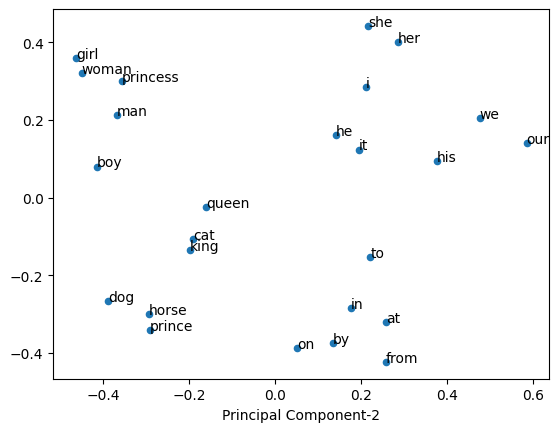

In [119]:
plt.scatter(x_vector,y_vector,s=20)
for i, word in enumerate(words):
  plt.annotate(word,(x_vector[i],y_vector[i]))

plt.xlabel("Principal Component-1")
plt.xlabel("Principal Component-2")
plt.show()